In [1]:
from datetime import datetime, date, timedelta
from enum import Enum, auto
from tqdm import tqdm
from typing import *

import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import requests

<h4>Менять активы для которых будет проведен анализ тут BASE_ASSETS</h4>

In [2]:
BASE_ASSETS: List[str] = [
    "BTC", "ETH", "TON", "SOL", "TRX", "XRP", "BNB", "SUI",
    "ZETA", "NEAR", "KAS", "FTM", "FXS"
]

SYMBOLS: List[str] = [
    f"{asset}USDT" for asset in BASE_ASSETS
] # создаем список тикеров (будем строить портфели из активов, которые торгуются против USDT)

<h4>Выгрузим данные о торгах</h4>

https://binance-docs.github.io/apidocs/spot/en/#kline-candlestick-data

In [3]:
# Колонки которые приходят с api Binance
BINANCE_KLINE_COLS: List[str] = [
    "open_time", "open", "high", "low", "close", "volume", "close_time", "quote_asset_volume",
    "num_trades", "taker_buy_base_volume", "taker_buy_quote_volume", "unused"
]

NUMERIC_COLS: List[str] = ["open", "high", "low", "close"] # колонки которые будут сведены к числовому типу

In [4]:
def preprocess_data(data: List[List[float]]) -> pd.DataFrame:
    """Load data to dataframe and preprocess it"""
    df: pd.DataFrame = pd.DataFrame(data, columns=BINANCE_KLINE_COLS)
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")

    for col in NUMERIC_COLS:
        df[col] = df[col].astype(float)
    
    return df


def query_data(start_ts: float, symbol: str, interval: str = "1d") -> pd.DataFrame:
    """Загружаем свечки из Binance API для одного offset - start_ts"""
    params: Dict[str, Any] = {
        "symbol": symbol, # наименование тикера который выгружаем
        "interval": interval, # интервал свечек
        "startTime": int(start_ts * 1000), # timestamp в миллисекундах
        "limit": 1000 # load 1000 candles at a time (max)
    }
    
    data: List[List[float]] = requests.get("https://api.binance.com/api/v3/klines", params=params).json()
    df: pd.DataFrame = preprocess_data(data=data)
    
    return df

def get_last_ts_from_data(df: pd.DataFrame) -> float:
    """Возвращает секундный timestamp последней выгруженной свечки"""
    return df["close_time"].max().timestamp()

def load_data(start_time: datetime, end_time: datetime, symbol: str, interval: str = "1d") -> pd.DataFrame:
    """Загружаем данные за весь промежуток времени (start_time; end_time)"""
    df_all: pd.DataFrame = pd.DataFrame()
    
    start_ts: float = start_time.timestamp() # timestamp секундный начала и конца интервала выгрузки данных
    end_ts: float = end_time.timestamp()
    
    while True:
        df: pd.DataFrame = query_data(start_ts=start_ts, symbol=symbol, interval=interval)
        # если данных для тикера нет, тк api возвращает любые первые 1000 свечек после start_tinme => нужно выходить из цикла
        if df.empty:
            return pd.DataFrame()
            
        df_all = pd.concat([df_all, df])
        last_kline_ts: float = get_last_ts_from_data(df=df)
        
        if last_kline_ts >= end_ts: # если мы выгрузили данных больше, чем надо, останавливаемся
            break

    # Клипнем последний датасет по нужному времени
    return (
        df_all[(start_time <= df_all["open_time"]) & (df_all["close_time"] <= end_time)]
        .reset_index(drop=True)
    )

<h4>Соберем данные для все тикеров за нужные период времени</h4>

In [5]:
def collect_data(start_time: datetime, end_time: datetime, symbols: List[str]) -> pd.DataFrame:
    """
    Функция которая соберает данные по свечкам с Binance по всем переданным symbols за промежуток времени (start_time, end_time)
    """
    df: pd.DataFrame = pd.DataFrame()
    
    for symbol in tqdm(SYMBOLS, desc="Collecting Kline data for symbols"):
        df_symbol: pd.DataFrame = load_data(
            start_time=start_time, end_time=end_time, symbol=symbol, interval="1d"
        )
        df_symbol["symbol"] = symbol # добавим тикер до того как склеить все данные
        df = pd.concat([df, df_symbol])

    df_close: pd.DataFrame = df.pivot(index="open_time", columns="symbol", values="close") # перевели данные из long в wide формат
    return df_close

<h4>Выгружаем данные тут, можно менять даты за которые будут выгружаться данные: start_date, end_date</h4>

In [6]:
# Оставим только колонку open_time и close цену, которые нам нужны для построения портфелей
start_time: datetime = datetime(year=2023, month=1, day=1) # менять интервал можно тут
end_time: datetime = datetime.now()

df_close: pd.DataFrame = collect_data(
    start_time=start_time, end_time=end_time, symbols=SYMBOLS
)

In [7]:
# Загрузим данные по TON
df_ton: pd.DataFrame = pd.read_csv("Toncoin Historical Data.csv")

df_ton["Date"] = pd.to_datetime(df_ton["Date"])
df_ton = df_ton.set_index("Date")

df_ton.head(2)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-10-11,5.2277,5.1376,5.2326,5.1229,5.14M,1.76%
2024-10-10,5.1372,5.0786,5.1387,4.9980,5.29M,1.15%


In [8]:
df_close["TONUSDT"] = df_ton["Open"]
df_close.head(2)

symbol,BNBUSDT,BTCUSDT,ETHUSDT,FTMUSDT,FXSUSDT,NEARUSDT,SOLUSDT,SUIUSDT,TONUSDT,TRXUSDT,XRPUSDT
open_time,,,,,,,,,,,
2023-01-01,244.4,16616.75,1200.34,0.2008,4.427,1.276,9.99,NaN,2.1819,0.05481,0.3387
2023-01-02,245.2,16672.87,1214.00,0.2105,4.649,1.314,11.28,NaN,2.3067,0.05517,0.3482


In [9]:
# посчитаем дневные log доходности
df_returns: pd.DataFrame = pd.DataFrame()

for col in df_close.columns:
    df_returns[col] = np.log(df_close[col] / df_close[col].shift(1))
    
df_returns.head(2)

,BNBUSDT,BTCUSDT,ETHUSDT,FTMUSDT,FXSUSDT,NEARUSDT,SOLUSDT,SUIUSDT,TONUSDT,TRXUSDT,XRPUSDT
open_time,,,,,,,,,,,
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,0.003268,0.003372,0.011316,0.047176,0.04893,0.029346,0.121447,NaN,0.055622,0.006547,0.027662


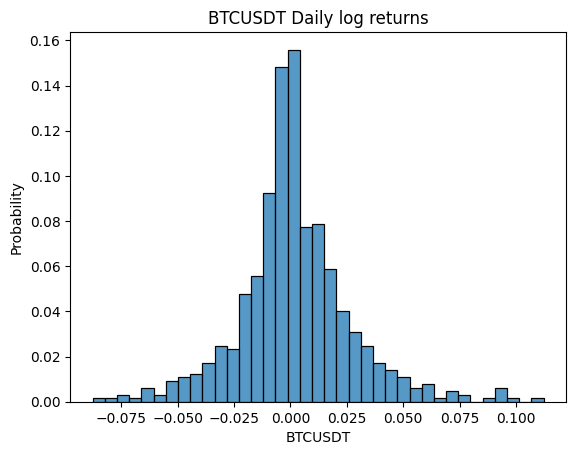

In [10]:
sns.histplot(df_returns, x="BTCUSDT", stat="probability")
plt.title("BTCUSDT Daily log returns")

plt.show()

<p>Важно: два актива были залистены на Binance относительно недавно, соответсвенно у них много пропусков в данных</p>

Binance, the world's largest cryptocurrency exchange, has announced that it will list TON tokens on August 8, 2024, at 10:00 UTC. Along with the listing, Binance will introduce a seed tag, and trading pairs such as TON/BTC, TON/USDT, and TON/FDUSD will be available.

In [11]:
df_returns.isna().sum()

BNBUSDT       1
BTCUSDT       1
ETHUSDT       1
FTMUSDT       1
FXSUSDT       1
NEARUSDT      1
SOLUSDT       1
SUIUSDT     123
TONUSDT       1
TRXUSDT       1
XRPUSDT       1
dtype: int64

In [12]:
df_returns.head(3)

,BNBUSDT,BTCUSDT,ETHUSDT,FTMUSDT,FXSUSDT,NEARUSDT,SOLUSDT,SUIUSDT,TONUSDT,TRXUSDT,XRPUSDT
open_time,,,,,,,,,,,
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,0.003268,0.003372,0.011316,0.047176,0.048930,0.029346,0.121447,NaN,0.055622,0.006547,0.027662
2023-01-03,0.003664,0.000139,0.000453,0.017425,0.047468,0.015855,0.169982,NaN,-0.029521,-0.006182,-0.013299


<h4>Теперь мы можем строить портфели</h4>

В качестве основы мы возьмем Markowtz Portfolio theory:

Предположим, что у нас нет возможности инвестировать в безрисковый актив: соотственно оптимальный порфтель - это портфель, который минимизирует дисперсию доходностей при какой-то фиксированной ожидаемой доходности:

$$
    \begin{align*}
    & \underset{\mathbf{w}}{\text{minimize}} & & \mathbb{V}ar(R_t) = \mathbf{w}^T \Sigma \mathbf{w} \\
    & \text{subject to} & & \mathbb{E}(R_t) = \mathbf{\mu}^T \mathbf{w} = R_t \\
    &&& \sum_{j=1}^{n} w_j = 1 \\
    &&& w_j \geq 0, \quad j=1,\ldots,n
    \end{align*}
$$

<h4>Еще раз задаем список тикеров для которых будет проведен бэктест на исторических данных. Оставляйте только те активы для которых есть данные за весь промежуток иначе будут ошибки и неправильные портфели: portfolio_assets</h4>

In [13]:
# Для тикера ZETAUSDT не было данных, тк он еще не залистился на бинансе, поэтому создадим список активов для которых есть данные
# и которые будут использоваться в построении портфеля
portfolio_assets: List[str] = [
    'BNBUSDT', 'BTCUSDT', 'ETHUSDT', 'FTMUSDT', 'FXSUSDT', 'NEARUSDT',
    'SOLUSDT', 'TRXUSDT', 'XRPUSDT', 'TONUSDT'
]
portfolio_assets

['BNBUSDT',
 'BTCUSDT',
 'ETHUSDT',
 'FTMUSDT',
 'FXSUSDT',
 'NEARUSDT',
 'SOLUSDT',
 'TRXUSDT',
 'XRPUSDT',
 'TONUSDT']

In [14]:
cov_matrix: np.ndarray = df_returns[portfolio_assets].cov() # ковариационная матрица доходностей активов
R: np.ndarray = df_returns[portfolio_assets].mean().values # вектор средних дневных лог доходностей
daily_target_return: float = 0.15 / 365 # доходность которую мы фиксируем

In [15]:
from scipy.optimize import minimize

def variance_objective(W: np.ndarray) -> float:
    """Фукнция которую мы будем минимизировать с помощью scipy.optimize.minimize"""
    portfolio_var: float = W @ cov_matrix @ W.T
    return portfolio_var # -> скаляр - дисперсия доходности портфеля

def weights_constraint(W: np.ndarray) -> float:
    """Ограничение на то, что в сумме веса нашего портфеля должны быть (мы не рассматриваем случай с возможностью шорта)"""
    return W.sum() - 1

def expected_return_constraint(W: np.ndarray) -> float:
    return np.dot(W, R) - daily_target_return

# Добавляем все ограничения в этот список
constraints: List[Dict[str, Any]] = [
    {"type": "eq", "fun": weights_constraint},
    {"type": "ineq", "fun": expected_return_constraint}
]

bounds: List[Tuple[float, float]] = [
    (0, 1) for asset in portfolio_assets
] # создадим ограничение на каждый вес, что w_i лежит в интервале от 0 до 1

In [16]:
x0 = [0.1] * len(portfolio_assets) # задаем стартовую точку с которой солвер будет искать минимум variance_objective

res = minimize(
    fun=variance_objective,
    x0=x0,
    bounds=bounds,
    constraints=constraints,
)

res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.00033354214083059527
       x: [ 1.503e-01  1.385e-01  1.137e-01  0.000e+00  2.108e-02
            0.000e+00  0.000e+00  2.102e-01  1.037e-01  2.625e-01]
     nit: 11
     jac: [ 6.716e-04  6.652e-04  7.563e-04  1.101e-03  9.738e-04
            1.021e-03  9.939e-04  4.359e-04  8.462e-04  7.165e-04]
    nfev: 121
    njev: 11

In [17]:
res.x.round(3) # оптимальный портфель в таком случае

array([0.15 , 0.138, 0.114, 0.   , 0.021, 0.   , 0.   , 0.21 , 0.104,
       0.262])

<h4>Мы теперь умеем находить портфель, который будет минимизировать дисперсию доходности при заданом уровне ожидаемой доходности</h4>

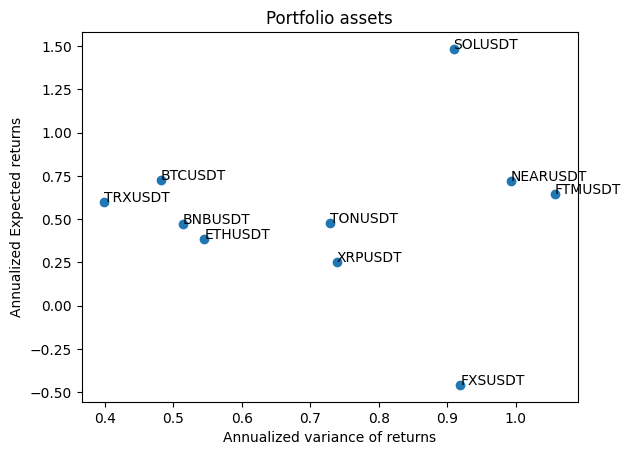

In [18]:
Sigma_annual: np.ndarray = np.sqrt(np.diag(cov_matrix) * 365)
R_annual: np.ndarray = R * 365

plt.scatter(Sigma_annual, R_annual)

for i, asset in enumerate(portfolio_assets):
    plt.annotate(
        asset, (Sigma_annual[i], R_annual[i]), fontsize=10
    )

plt.title("Portfolio assets")

plt.xlabel("Annualized variance of returns")
plt.ylabel("Annualized Expected returns")
plt.show()

<h4>Вместо минимизации дисперсии при фиксированном доходе, мы можем максимизировать премию за риск или Sharpe Ratio</h4>

$$\text{Sharpe ratio} = \frac{<W, R>}{\sqrt{W^T \Sigma W}} \rightarrow max$$

In [19]:
def sharpe_objective(W: np.ndarray) -> float:
    sigma_p = np.sqrt(W @ cov_matrix @ W.T)
    return -np.dot(W, R) / sigma_p # добавим минус, чтобы мы максимизировали

def weights_constraint(W: np.ndarray) -> float:
    """Ограничение на то, что в сумме веса нашего портфеля должны быть (мы не рассматриваем случай с возможностью шорта)"""
    return W.sum() - 1
    
bounds: List[Tuple[float, float]] = [
    (0, 1) for asset in portfolio_assets
] # создадим ограничение на каждый вес, что w_i лежит в интервале от 0 до 1

# Теперь нам не нужно ограничение на фиксированную ожидаемую доходность
constraints: List[Dict[str, Any]] = [
    {"type": "eq", "fun": weights_constraint},
]

x0 = [0.1] * len(portfolio_assets) # задаем стартовую точку с которой солвер будет искать максимум sharpe_objective

In [20]:
res = minimize(
    fun=sharpe_objective,
    x0=x0,
    bounds=bounds,
    constraints=constraints,
)

res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.10620255681248932
       x: [ 4.149e-17  1.733e-01  0.000e+00  4.440e-17  4.957e-17
            0.000e+00  1.944e-01  4.253e-01  0.000e+00  2.071e-01]
     nit: 11
     jac: [ 1.890e-02  4.455e-04  5.292e-02  8.875e-02  2.011e-01
            6.696e-02 -3.357e-04 -1.068e-04  6.756e-02  1.616e-04]
    nfev: 121
    njev: 11

In [21]:
pd.DataFrame({
    "asset": portfolio_assets,
    "weight_sharpe_portfolio": res.x.round(4)
})

,asset,weight_sharpe_portfolio
0,BNBUSDT,0.0000
1,BTCUSDT,0.1733
2,ETHUSDT,0.0000
3,FTMUSDT,0.0000
4,FXSUSDT,0.0000
5,NEARUSDT,0.0000
6,SOLUSDT,0.1944
7,TRXUSDT,0.4253
8,XRPUSDT,0.0000
9,TONUSDT,0.2071


Сейчас обернем всю логику с построением портфеля в одну функцию и будем калибровать порфтелю по критерию max Sharpe ratio, каждый квартал и строить доходности портфеля

<h4>Менять логику построения портфелей можно тут, определив свой класс который выполняет интерфейс PortfolioFinder</h4>

In [22]:
from abc import ABC, abstractmethod


class PortfolioFinder(ABC):
    """Cand define any objective but it must implement find_portfolio method"""

    def __init__(self) -> Self:
        super().__init__()

    @abstractmethod
    def find_portfolio(self, df_returns: pd.DataFrame) -> np.array:
        """Finds optimal portfolio"""


class MaxSharpeOptimizer(PortfolioFinder):

    def __init__(self) -> Self:
        super().__init__()

    @staticmethod
    def max_sharpe_objective(W: np.array, df_returns: pd.DataFrame) -> float:
        """Функция которую мы максимизируем"""
        sigma_p = np.sqrt(W @ df_returns.cov() @ W.T)
        R = df_returns.mean()
        return -np.dot(W, R) / sigma_p # -> максимизируем Sharpe ratio

    @staticmethod
    def weight_constraint(W: np.ndarray) -> float:
        return W.sum() - 1

    @staticmethod
    def hh_constraint(W: np.ndarray) -> float:
        return -(np.sum(W**2) - 0.5)

    def find_portfolio(self, df_returns: pd.DataFrame) -> np.ndarray:
        """Optimize for MaxSharpe ratio"""
        # Задаес ограничения на веса портфеля
        constraints = [
            {"type": "eq", "fun": self.weight_constraint},
            # {"type": "ineq", "fun": self.hh_constraint} # можно добавить ограничение на HH index
        ]
        # создадим ограничение на каждый вес, что w_i лежит в интервале от 0 до 1
        n_assets: int = df_returns.shape[1]
        bounds: List[Tuple[float, float]] = [(0, 1) for _ in range(n_assets)]

        n_assets: int = df_returns.shape[1] # количество активов из которых строится портфель
        x0 = [1 / n_assets] * n_assets
        
        res = minimize(
            fun=self.max_sharpe_objective,
            x0=x0,
            bounds=bounds,
            constraints=constraints,
            args=(df_returns,)
        )
        
        assert res.success, "Солвер вернул ошибку, что-то не так с оптимизацией, может быть стоит попробовать другой солвер"
        
        return res.x

<h4>Реализуем основной функционал бектеста портфельной стратегии</h4>

In [23]:
class Trainer:
    
    def __init__(self, df_returns: pd.DataFrame, optimizer: PortfolioFinder) -> Self:
        self.df_returns: pd.DataFrame = df_returns
        self.optimizer: PortfolioFinder = optimizer
        self.test_log: List[Dict[str, Any]] = []

    def backtest(self, df_test: pd.DataFrame, W_star: np.array) -> None:
        asset_returns: np.array = (1 + df_test).cumprod().iloc[-1].values # get asset cumulative returns on the last day

        portfolio_return: float = np.dot(W_star, asset_returns)
        portfolio_max_daily_drawdown: float = ((1 + df_test) @ W_star).min() # find the worst daily return in df_test
        hh_index: float = np.sum(W_star**2)

        self.test_log.append({
            "portfolio_return": portfolio_return,
            "portfolio_max_daily_drawdown": portfolio_max_daily_drawdown,
            "hh_index": hh_index,
            "portfolio_weights": W_star,
            "time": df_test.index[-1]
        })

    def train(self, train_size: int, test_size: int, clean_log: bool = True):
        """Perform sliding window optimization and backtest of the strategy"""
        if clean_log:
            self.test_log = []

        for i in tqdm(
            range(0, self.df_returns.shape[0] - train_size - test_size, test_size)
        ):
            
            df_train = self.df_returns.iloc[i:(i+train_size)].copy()
            df_test = self.df_returns.iloc[(i+train_size):(i+train_size+test_size)].copy()
            
            W_star: np.array = self.optimizer.find_portfolio(df_returns=df_train)
            self.backtest(df_test=df_test, W_star=W_star)


    def plot_results(self) -> None:
        """Get data from test_log and display main metrics"""
        df_test = pd.DataFrame(self.test_log)
        df_test["cumprod_return"] = df_test["portfolio_return"].cumprod()

        fig, axs = plt.subplots(1, 3, figsize=(20, 5))
        ax1, ax2, ax3 = axs

        df_test.plot(x="time", y="cumprod_return", ax=ax1, title="Cumulative return")
        df_test.plot(x="time", y="portfolio_max_daily_drawdown", ax=ax2, title="Max daily drawdown")
        df_test.plot(x="time", y="hh_index", ax=ax3, title="HH_index")

        plt.show()

Herfindahl-hirschman index - показывает насколько сконцентрирован портфель в одном активе:

$$\text{HH index} = \sum_{i \in I} w_i^2$$

<h4>Запускаем бэктест портфелей с помощью MaxhSharpeOptimizer. train_size - длина тренировочного интервала, на котором считается ковариационная матрица и вектор доходностей, test_size - как часто мы держим и рекалибруем построенный на trainе портфель</h4>

In [24]:
optimizer: PortfolioFinder = MaxSharpeOptimizer()

trainer = Trainer(
    df_returns=df_returns[portfolio_assets], optimizer=optimizer
)
trainer.train(train_size=90, test_size=30)

100%|██████████| 18/18 [00:01<00:00, 10.99it/s]


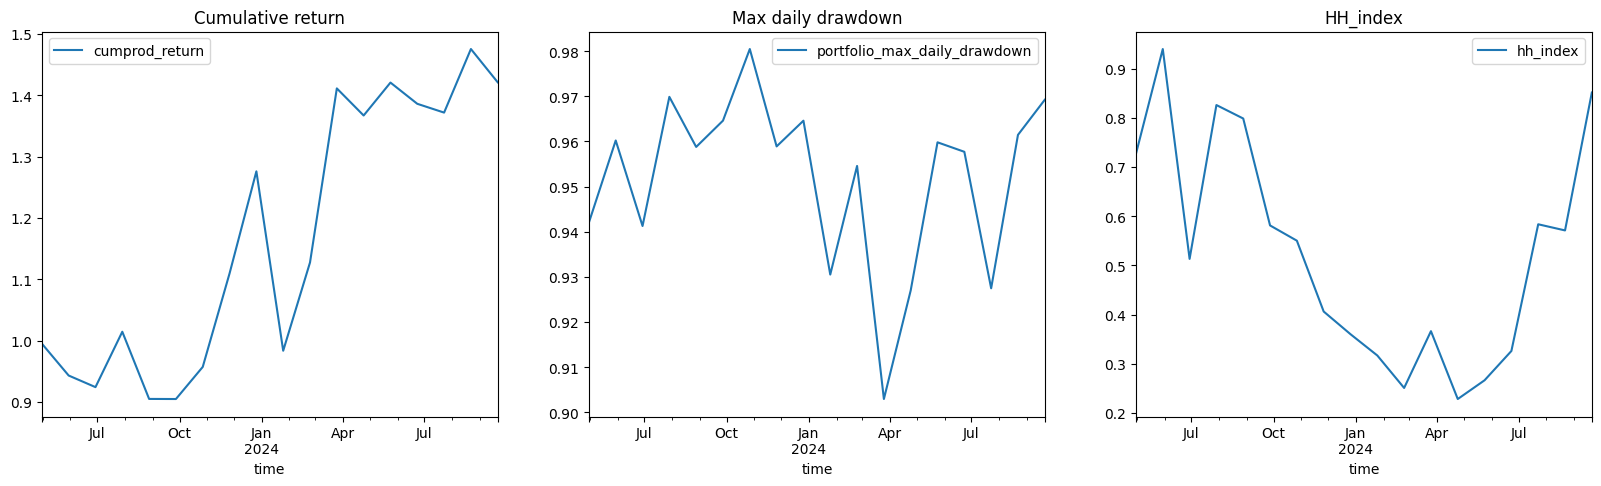

In [25]:
trainer.plot_results()

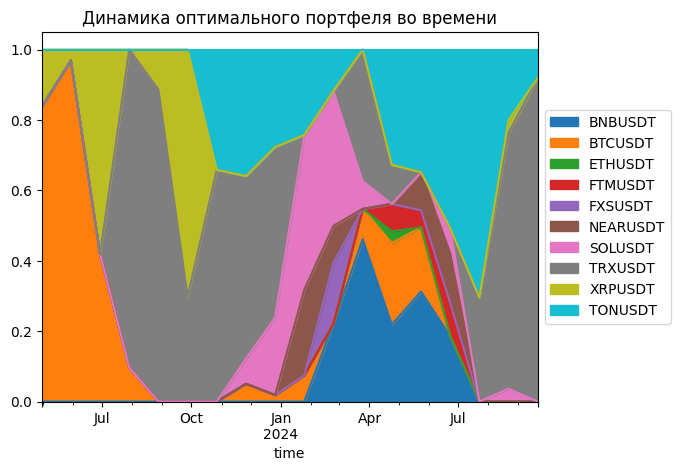

In [26]:
weights: List[np.ndarray] = [log["portfolio_weights"] for log in trainer.test_log]
times: List[pd.Timestamp] = [log["time"] for log in trainer.test_log]
 
df_weights: pd.DataFrame = pd.DataFrame(weights)

df_weights["time"] = times
df_weights = df_weights.set_index("time")

df_weights.columns = portfolio_assets
df_weights.plot.area()

plt.title("Динамика оптимального портфеля во времени")
plt.legend(loc="center left",bbox_to_anchor=(1.0, 0.5))

plt.show()

<h4>Оптимальный портфель сейчас со всеми активами, тк данные есть по всем из них за последние 90 дней</h4>

In [27]:
# Возьмем лог доходности за последние 90 дней
today: date = date.today()
df_last_90days: pd.DataFrame = df_returns.loc[
    df_returns.index > pd.Timestamp(today - timedelta(days=90)) # фильтр на последние 90 дней
].copy()

# Используем наш PortfolioFinder 
optimizer: PortfolioFinder = MaxSharpeOptimizer()
optimal_weights: np.ndarray = optimizer.find_portfolio(
    df_returns=df_last_90days
)

In [28]:
pd.DataFrame({
    "asset": df_last_90days.columns,
    "weight": optimal_weights.round(3)
})

,asset,weight
0,BNBUSDT,0.000
1,BTCUSDT,0.000
2,ETHUSDT,0.000
3,FTMUSDT,0.000
4,FXSUSDT,0.000
5,NEARUSDT,0.000
6,SOLUSDT,0.000
7,SUIUSDT,0.497
8,TONUSDT,0.000
9,TRXUSDT,0.503


In [29]:
returns: np.ndarray = np.array([log["portfolio_return"] for log in trainer.test_log]) * 12

sharpe: float = returns.mean() / returns.std()
sharpe

np.float64(9.464507172855694)